#### Overview

This notebook contains the code to reproduce our experiments in the paper, namely
- A simple demonstration of the max-rank correction, in 5 lines of code only,
- Our simulation study and comparison to Bonferroni (sec. 5 in the paper),
- Our conformal multi-target regression experiments (sec. 6.2, Table 1 in the paper),
- A description on how to set up the conformal bounding box experiment (sec. 6.2, Fig. 3 in the paper).

#### Imports

In [1]:
# assert curr work dir is set to parent dir of this file (adjust as necessary)
import os
wdir = os.getcwd()
assert wdir.split("/")[-1] == "max-rank"

In [2]:
# for simulations 
import numpy as np

# for multi-target regression
import json
import pandas as pd
from tqdm import tqdm
from scipy.io import arff
from copulae import GumbelCopula, EmpiricalCopula, pseudo_obs
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# for figures
import matplotlib.pyplot as plt
from plot_style import *   # set usetex=True if latex support available

In [3]:
def save_fig(figname: str, **kwargs):
    plt.savefig(figname + ".pdf", format="pdf", **kwargs)
    print(f"Saved figure {figname}.")

Note: ```copulae``` seems incompatible with ```numpy >= 2.0``` as of now, so it is safer to go with ```python < 3.10, numpy < 2.0, scipy < 1.15``` if copula baselines are desired (see also https://github.com/DanielBok/copulae/issues).

#### Simple demonstration of max-rank

In [212]:
alpha = 0.1; n = 1000; m = 5; corr = 1.0 # params

# create correlated score matrix
cov = np.full((m, m), corr)
np.fill_diagonal(cov, 1)
S = np.random.multivariate_normal(np.zeros(m), cov, n)

# max-rank correction
R = np.argsort(np.argsort(S, axis=0), axis=0) # rank matrix
r_max = np.max(R, axis=1) # row-wise max-rank vec(r)_max
q = np.ceil((1 - alpha) * (n + 1)) / n # conformal target coverage level
rank_q = np.quantile(r_max, q, axis=0, method='higher') # quantile r_max
adj_quantile = np.sort(S, axis=0)[rank_q] # final corrected quantiles

print(f"Adjusted significance level: {(1 - (rank_q + 1) / (n + 1)):.2f}")
print(f"Adjusted quantiles: {adj_quantile}")

Adjusted significance level: 0.10
Adjusted quantiles: [1.26590383 1.26590384 1.26590384 1.26590384 1.26590384]


Note: Thank you to [Filip Schlembach](https://www.maastrichtuniversity.nl/f-schlembach) for pointing out two improvements to the demo code: ```np.quantile(..., method='inverted_cdf')``` yields slightly less conservative results than ```np.quantile(..., method='higher')``` while maintaining the desired interpretation, and ```(1 - (rank_q + 1) / (n + 1)``` over ```(1 - rank_q / n)``` fixes an indexing underestimation in reporting the adjusted level (only noticeable for small n). For consistency with reported results in the paper we continue with ```np.quantile(..., method='higher')```.

#### Simulation study and comparison to Bonferroni

In [4]:
def conf_quantile(n, scores, alpha):
    q = np.clip(np.ceil((1 - alpha) * (n + 1)) / n, 0, 1)
    return np.quantile(scores, q, axis=0, method='higher')

def bonf(scores, alpha):
    n, m = scores.shape
    alpha_bonf = alpha / m
    q = conf_quantile(n, np.arange(1, n+1), alpha_bonf)
    q = (q - 1) if q == n else q # accessible index
    return np.sort(scores, axis=0)[q]

def maxrank(scores, alpha):
    n, _ = scores.shape
    ranks = np.argsort(np.argsort(scores, axis=0), axis=0)
    max_ranks = np.max(ranks, axis=1)
    q_rank = conf_quantile(n, max_ranks, alpha)
    return np.sort(scores, axis=0)[q_rank]

def cover(X, q):
    return np.all(X < q[None, :], axis=1).mean()

def cover_dim(X, q):
    return (X < q[None, :]).mean(axis=0)


In [5]:
alpha = 0.1; n = 10000; m = 5; corr = 1.0

cov = np.full((m, m), corr)
np.fill_diagonal(cov, 1)
X = np.random.multivariate_normal(np.zeros(m), cov, n)
X_test = np.random.multivariate_normal(np.zeros(m), cov, n)

print(f"Target coverage: {1-alpha}")

q_bonf = bonf(X, alpha)
print(f"\nBonferroni quantiles: {q_bonf}")
print(f"Bonferroni coverage global: {cover(X_test, q_bonf)}")
print(f"Bonferroni coverage per dim: {cover_dim(X_test, q_bonf)}")

q_maxrank = maxrank(X, alpha)
print(f"\nMax-rank quantiles: {q_maxrank}")
print(f"Max-rank coverage global: {cover(X_test, q_maxrank)}")
print(f"Max-rank coverage per dim: {cover_dim(X_test, q_maxrank)}")

Target coverage: 0.9

Bonferroni quantiles: [2.08706609 2.08706609 2.08706609 2.08706609 2.08706609]
Bonferroni coverage global: 0.9806
Bonferroni coverage per dim: [0.9806 0.9806 0.9806 0.9806 0.9806]

Max-rank quantiles: [1.29094522 1.29094521 1.29094521 1.29094521 1.29094521]
Max-rank coverage global: 0.9002
Max-rank coverage per dim: [0.9002 0.9002 0.9002 0.9002 0.9002]


Global FWER control/coverage for different correlations

In [7]:
alpha = 0.05
n = 10000
m = np.array([1, 3, 5, 10, 20])
corr = np.arange(0, 1.1, 0.1)
num_trials = 10

cov_bonf_tr = np.zeros((num_trials, len(m), len(corr)))
cov_maxrank_tr = np.zeros((num_trials, len(m), len(corr)))


In [8]:
for trial in tqdm(range(num_trials), desc="Trials"):
    for idx_m in tqdm(range(len(m)), desc="Dimensions", leave=False):
        
        mtest = m[idx_m]
        mean = np.zeros(mtest)
        
        for idx, i in enumerate(corr):
            
            cov = np.full((mtest, mtest), i)
            np.fill_diagonal(cov, 1)
            
            X = np.random.multivariate_normal(mean, cov, n)
            X_test = np.random.multivariate_normal(mean, cov, n)
            
            q_bonf = bonf(X, alpha)
            cov_bonf_tr[trial, idx_m, idx] = cover(X_test, q_bonf)
            q_maxrank = maxrank(X, alpha)
            cov_maxrank_tr[trial, idx_m, idx] = cover(X_test, q_maxrank)
            
# np.save("cov_bonf_tr_global.npy", cov_bonf_tr)
# np.save("cov_maxrank_tr_global.npy", cov_n_trials)

Trials: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05')])

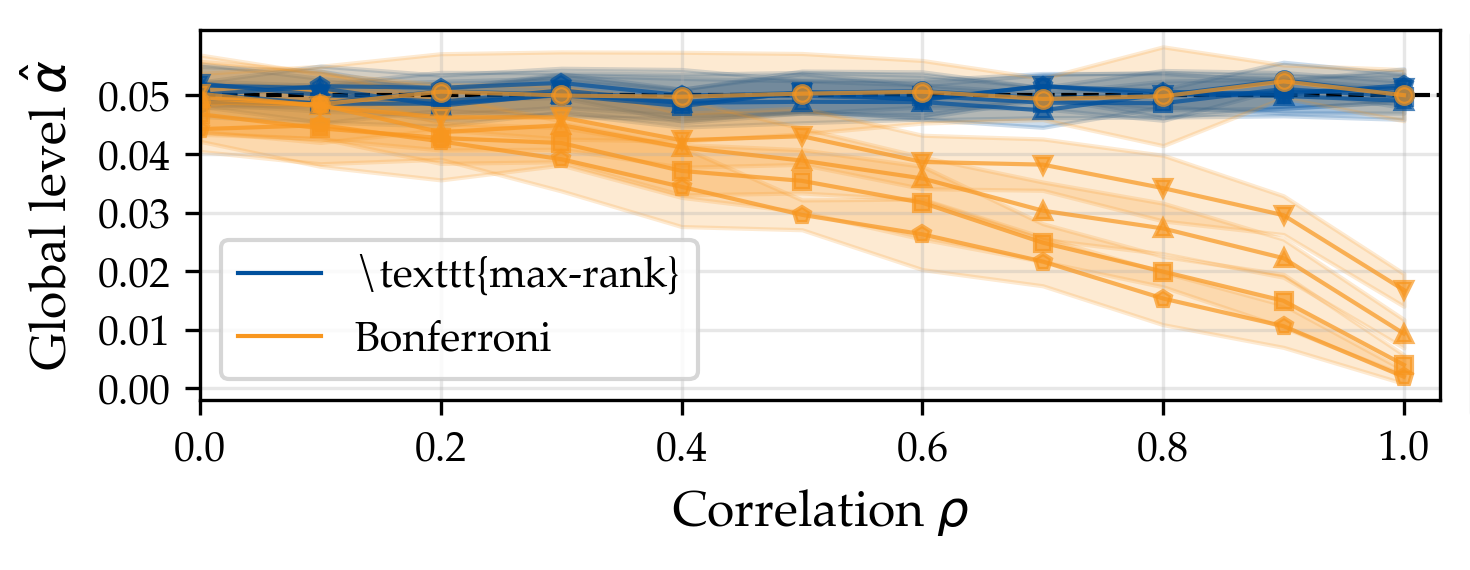

In [9]:
# Calculate mean and standard deviation across trials
cov_b_mean = np.mean(cov_bonf_tr, axis=0)
cov_b_std = np.std(cov_bonf_tr, axis=0)
cov_n_mean = np.mean(cov_maxrank_tr, axis=0)
cov_n_std = np.std(cov_maxrank_tr, axis=0)

# Plot figure
fig, ax = plt.subplots(figsize=(5, 2))

ax.axhline(y=alpha, color="black", linestyle="--", label=r"Desired level $\alpha$")

marker_symbols = ['o', 'v', '^', 's', 'p']  # Marker styles
colors = ["#00509D", "#F8961E"]
grey_marker = "#808080"  # Grey for markers

# Plot max-rank with shading
for idx_m, mtest in enumerate(m):
    ax.plot(corr, 1-cov_n_mean[idx_m], color=colors[0], linestyle='-', alpha=0.7, 
            marker=marker_symbols[idx_m % len(marker_symbols)], markersize=4, markerfacecolor=colors[0])

    ax.fill_between(corr, 1-(cov_n_mean[idx_m] + cov_n_std[idx_m]), 1-(cov_n_mean[idx_m] - cov_n_std[idx_m]), 
                    color=colors[0], alpha=0.2)

# Plot Bonferroni with shading
for idx_m, mtest in enumerate(m):
    ax.plot(corr, 1-cov_b_mean[idx_m], color=colors[1], linestyle='-', alpha=0.7, 
            marker=marker_symbols[idx_m % len(marker_symbols)], markersize=4, markerfacecolor=colors[1])

    ax.fill_between(corr, 1-(cov_b_mean[idx_m] + 2*cov_b_std[idx_m]), 1-(cov_b_mean[idx_m] - 2*cov_b_std[idx_m]), 
                    color=colors[1], alpha=0.2)

# Add dummy handles for the legend
h1, = ax.plot([], [], color=colors[0], linestyle='-', label=r"\texttt{max-rank}")  # Legend for max-rank
h2, = ax.plot([], [], color=colors[1], linestyle='-', label="Bonferroni")  # Legend for Bonferroni

# Dummy marker handles for m values
marker_handles = [ax.plot([], [], marker=marker_symbols[idx_m % len(marker_symbols)], color=grey_marker, 
                          linestyle='', markersize=4, label=f"$m={mtest}$")[0] for idx_m, mtest in enumerate(m)]

# Create the legend
legend1 = ax.legend(handles=[h1, h2], loc="lower left", fontsize=10)
legend2 = ax.legend(handles=marker_handles, title="Nr. of tests", loc="upper right", fontsize=10, bbox_to_anchor=(1.28, 1.065))

ax.add_artist(legend1)  # Ensure first legend remains

legend2.get_frame().set_facecolor("white")
# legend2.get_frame().set_edgecolor("grey")
# legend2.get_frame().set_alpha(0.7)
ax.add_artist(legend2)

ax.set_xlabel(r"Correlation $\rho$", fontsize=12)
ax.set_xlim(0, 1.03)
ax.set_ylabel(r"Global level $\hat{\alpha}$", fontsize=12)
ax.set_yticks(np.arange(0.0, 0.06, 0.01))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# fig.tight_layout()
# save_fig(f"global_cov_vs_corr")

Individual Type-I error control/coverage for different correlations

In [10]:
alpha = 0.05
n = 10000
m = 5
corr = np.arange(0, 1.1, 0.1)
num_trials = 10

cov_bonf_tr = np.zeros((num_trials, m, len(corr)))
cov_maxrank_tr = np.zeros((num_trials, m, len(corr)))


In [11]:
for trial in tqdm(range(num_trials), desc="Trials"):
    mean = np.zeros(m)
    
    for idx, i in enumerate(corr):
        
        cov = np.full((m, m), i)
        np.fill_diagonal(cov, 1)
        
        X = np.random.multivariate_normal(mean, cov, n)
        X_test = np.random.multivariate_normal(mean, cov, n)
        
        q_bonf = bonf(X, alpha)
        cov_bonf_tr[trial, :, idx] = cover_dim(X_test, q_bonf)
        q_maxrank = maxrank(X, alpha)
        cov_maxrank_tr[trial, :, idx] = cover_dim(X_test, q_maxrank)
            
# np.save("cov_bonf_tr_indiv.npy", cov_bonf_tr)
# np.save("cov_maxrank_tr_indiv.npy", cov_maxrank_tr)

Trials: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05')])

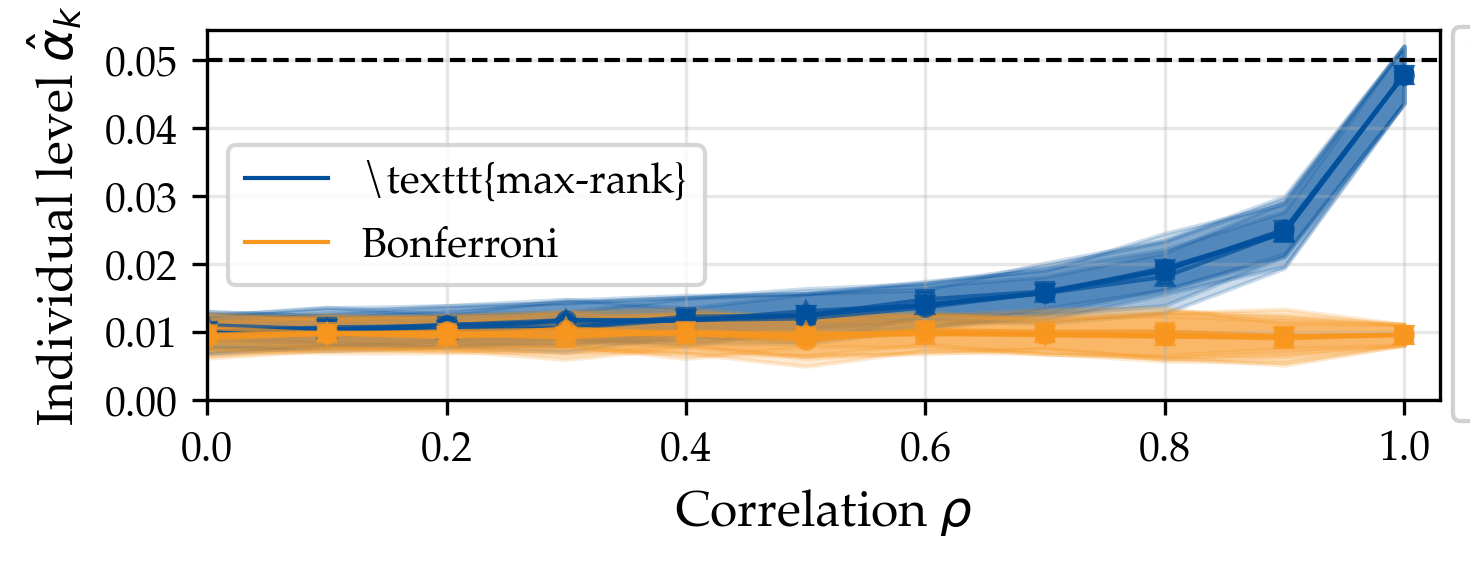

In [12]:
# Calculate mean and standard deviation across trials
cov_b_mean = np.mean(cov_bonf_tr, axis=0)
cov_b_std = np.std(cov_bonf_tr, axis=0)
cov_n_mean = np.mean(cov_maxrank_tr, axis=0)
cov_n_std = np.std(cov_maxrank_tr, axis=0)

# Plot figure
fig, ax = plt.subplots(figsize=(5, 2))

ax.axhline(y=alpha, color="black", linestyle="--", label=r"Desired level $\alpha$")

marker_symbols = ['o', 'v', '^', 's', 'p']  # Define a list of marker symbols
colors = ["#00509D", "#F8961E"]

# Plotting max-rank with shading for standard deviation
for mtest in range(m):
    ax.plot(corr, 1-cov_n_mean[mtest, :], color=colors[0], linestyle='-', alpha=0.7, marker=marker_symbols[mtest % len(marker_symbols)], markersize=4)
    ax.fill_between(corr, 1-(cov_n_mean[mtest, :] + 2*cov_n_std[mtest, :]), 1-(cov_n_mean[mtest, :] - 2*cov_n_std[mtest, :]), color=colors[0], alpha=0.2)

ax.axvline(x=1.1, color="white", linestyle="-", label=" ")

# Plotting Bonferroni with shading for standard deviation
for mtest in range(m):
    ax.plot(corr, 1-cov_b_mean[mtest, :], color=colors[1], linestyle='-', alpha=0.7, marker=marker_symbols[mtest % len(marker_symbols)], markersize=4)
    ax.fill_between(corr, 1-(cov_b_mean[mtest, :] + 2*cov_b_std[mtest, :]), 1-(cov_b_mean[mtest, :] - 2*cov_b_std[mtest, :]), color=colors[1], alpha=0.2)

# Add dummy handles for the legend
h1, = ax.plot([], [], color=colors[0], linestyle='-', label=r"\texttt{max-rank}")  # Legend for max-rank
h2, = ax.plot([], [], color=colors[1], linestyle='-', label="Bonferroni")  # Legend for Bonferroni

# Dummy marker handles for m values
marker_handles = [ax.plot([], [], marker=marker_symbols[mtest % len(marker_symbols)], color=grey_marker, 
                          linestyle='', markersize=4, label=f"$k={mtest+1}$")[0] for mtest in range(m)]

# Create the legend
legend1 = ax.legend(handles=[h1, h2], loc="center left", fontsize=10)
legend2 = ax.legend(handles=marker_handles, title="Test dimension", loc="upper right", 
                    fontsize=10, bbox_to_anchor=(1.28, 1.065)
                    )

ax.add_artist(legend1)  # Ensure first legend remains

legend2.get_frame().set_facecolor("white")
# legend2.get_frame().set_edgecolor("grey")
# legend2.get_frame().set_alpha(0.7)
ax.add_artist(legend2)

# Customize plot appearance
ax.set_xlabel(r"Correlation $\rho$", fontsize=12)
ax.set_xlim(0, 1.03)
ax.set_ylabel(r"Individual level $\hat{\alpha}_k$", fontsize=12)
ax.set_yticks(np.arange(0.0, 0.06, 0.01))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# fig.tight_layout()
# save_fig(f"indiv_cov_vs_corr")

FWER control and sample sizes

In [14]:
alpha = 0.05
samp = [100, 500, 1000]
nr_test = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 250, 500, 1000])
corr = [0.0, 0.25, 0.5, 0.75, 1.0]
num_trials = 10

cov_bonf = np.zeros((num_trials, len(samp), len(nr_test), len(corr)))
cov_maxrank = np.zeros((num_trials, len(samp), len(nr_test), len(corr)))

In [15]:
for trial in range(num_trials):
    print(f"\n--- Trial {trial+1} --- ")

    for n_i, n in enumerate(samp):
        print(f"{n=}.")
        
        for m in tqdm(nr_test, desc=f"Testing dimension"):
            m_i = nr_test.tolist().index(m)
            mean = np.zeros(m)
            
            for c_i, c in enumerate(corr):
                
                cov = np.full((m, m), c)
                np.fill_diagonal(cov, 1)

                X = np.random.multivariate_normal(mean, cov, size=n)
                X_test = np.random.multivariate_normal(mean, cov, size=n)

                q_bonf = bonf(X, alpha)
                cov_bonf[trial, n_i, m_i, c_i] = cover(X_test, q_bonf)
                q_maxrank = maxrank(X, alpha)
                cov_maxrank[trial, n_i, m_i, c_i] = cover(X_test, q_maxrank)

# np.save("plots/cov_bonf_tr_samp.npy", cov_bonf)
# np.save("plots/cov_maxrank_tr_samp.npy", cov_maxrank)


--- Trial 1 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]



--- Trial 2 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.52it/s] 


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]



--- Trial 3 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s] 


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]



--- Trial 4 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]



--- Trial 5 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]



--- Trial 6 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s] 


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]



--- Trial 7 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.95it/s]



--- Trial 8 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.11it/s]



--- Trial 9 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s] 


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]



--- Trial 10 --- 
n=100.


Testing dimension: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


n=500.


Testing dimension: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s] 


n=1000.


Testing dimension: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Text(0.52, -0.02, 'Nr. of tests $m$')

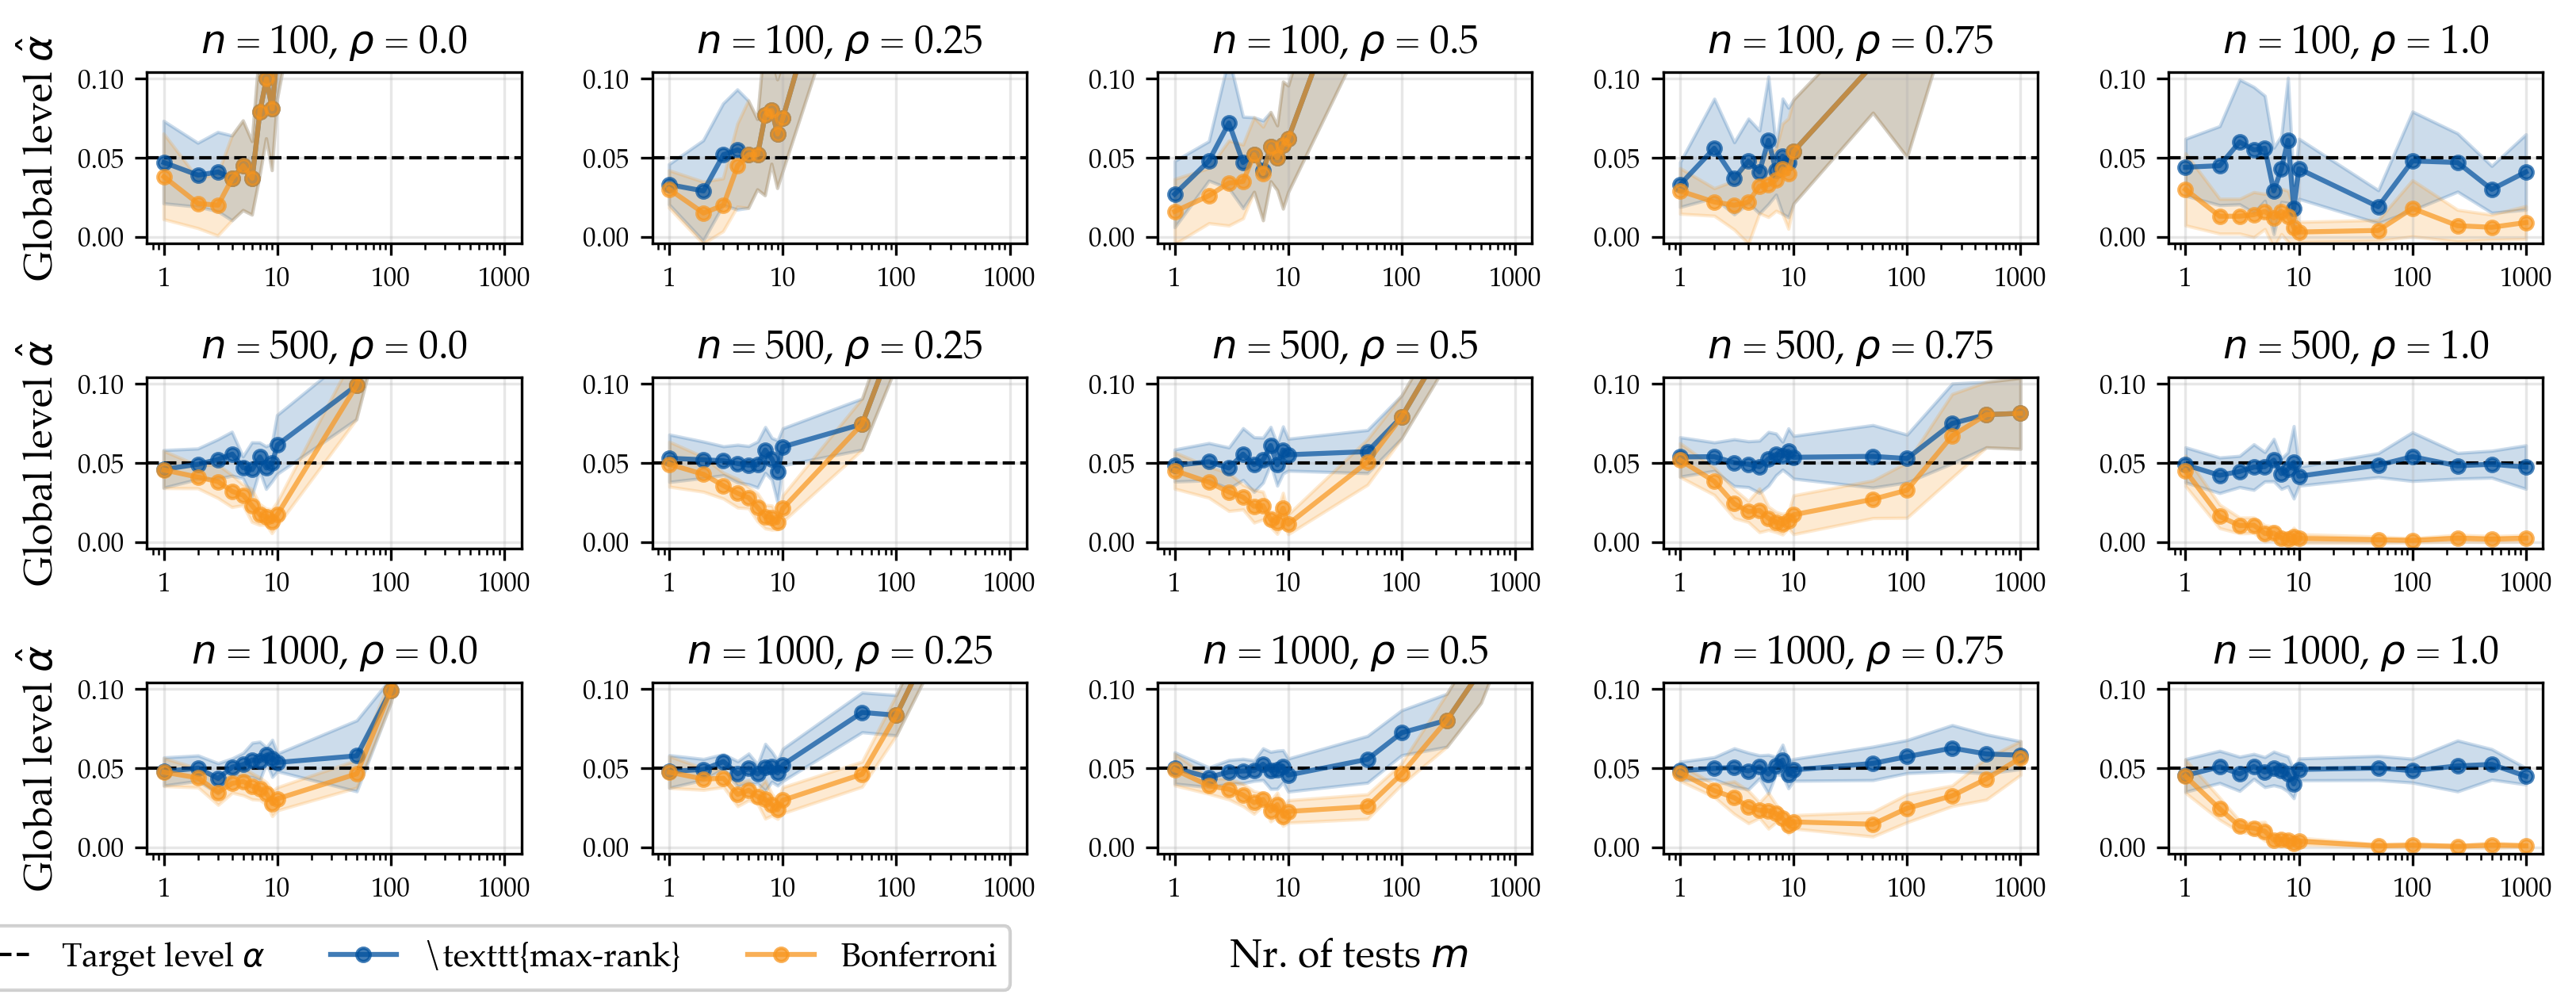

In [16]:
# Calculate mean and standard deviation across trials
cov_b_mean = np.mean(cov_bonf, axis=0)
cov_b_std = np.std(cov_bonf, axis=0)
cov_n_mean = np.mean(cov_maxrank, axis=0)
cov_n_std = np.std(cov_maxrank, axis=0)

lab = ["max-rank", "Bonferroni"]
colors = ["#00509D", "#F8961E"]
sizes = ["100", "500", "1000"]

fig, axs = plt.subplots(len(samp), len(corr), figsize=(11, 4))

rows, cols = axs.shape
for i in range(rows):
    
    axs[i, 0].set_ylabel(r"Global level $\hat{\alpha}$", fontsize=12)
    
    for j in range(cols):
        ax = axs[i, j]
        
        ax.axhline(y=alpha, color="black", linestyle="--", label=r"Target level $\alpha$")
        
        ax.plot(nr_test, 1-cov_n_mean[i, :, j], label=r"\texttt{max-rank}", color=colors[0], linestyle='-', linewidth=1.5, alpha=0.7, marker="o", markersize=4)
        ax.fill_between(nr_test, 1-(cov_n_mean[i, :, j] + cov_n_std[i, :, j]), 1-(cov_n_mean[i, :, j] - cov_n_std[i, :, j]), color=colors[0], alpha=0.2)
        
        ax.plot(nr_test, 1-cov_b_mean[i, :, j], label="Bonferroni", color=colors[1], linestyle='-', linewidth=1.5, alpha=0.7, marker="o", markersize=4)
        ax.fill_between(nr_test, 1-(cov_b_mean[i, :, j] + cov_b_std[i, :, j]), 1-(cov_b_mean[i, :, j] - cov_b_std[i, :, j]), color=colors[1], alpha=0.2)
        
        # ax.set_xlim(-1, mtest+1)
        
        ax.set_ylim(-0.004, 0.104)
        ax.set_yticks([0, 0.05, 0.1])
        
        # ax.set_xticks([0, 20, 40, 60, 80, 100])
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        ax.set_title(fr"$n$ = {sizes[i]}, $\rho$ = {corr[j]}", fontsize=12)
        # ax.set_ylabel(r"Global level $\hat{\alpha}$", fontsize=12)
        # ax.set_xlabel("Number of tests $m$", fontsize=12)
        ax.set_xscale("log")
        ax.set_xticks([1, 10, 100, 1000])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        # ax.xaxis.grid(False)
    
leg = axs[2, 0].legend(fontsize=10, ncol=3, bbox_to_anchor=(2.35, -0.33))
# leg.get_frame().set_edgecolor("black")
axs[2, 0].add_artist(leg)
fig.text(0.52, -0.02, 'Nr. of tests $m$', ha='center', va='center', fontsize=12)

# fig.tight_layout()
# save_fig(f"glob_cov_vs_tests_and_samp")

#### Conformal multi-target regression

Steps:
- Download data in ```.arff``` format from the [Mulan Repository](https://github.com/tsoumakas/mulan/tree/master/data/multi-target). We consider datasets ```rf1, scm1d, scpf``` in the paper, stored in a folder ```data/...```.
- Preprocess the data into digestible ```.csv``` formats with some data clean-up using preprocessing code from [Messoudi et al.](https://github.com/M-Soundouss/CopulaConformalMTR/blob/master/code/prepare_data.py).
- Define the necessary conformal metrics, multiple testing corrections, training and evaluation pipelines using ```scikit-learn```.
- Run main loop and write evaluation results stored in dictionaries to ```.json``` files.

In [221]:
dataset_names = [
        "scpf",
        "rf1",
        "scm1d",
    ]
n_targets = [3, 8, 16]
datasets = list(zip(dataset_names, n_targets))

print(datasets)

[('scpf', 3), ('rf1', 8), ('scm1d', 16)]


In [222]:
def mulan_read_json(dataset_names, n_targets, datasets, data_path):
    
    for ds_name, n_target in datasets:
        print("Transforming:", ds_name)
        
        csv_file = os.path.join(data_path, ds_name + ".csv")
        data = arff.loadarff(os.path.join(data_path, ds_name + ".arff"))
        
        df = pd.DataFrame(data[0])
        df = df.fillna(df.median(axis=0))
        df_col = len(df.columns) + 1
        df.columns = [f"v_{i}" for i in range(1, df_col)]
        df.to_csv(
            csv_file, sep=",", index=False,
        )
        
        df_var = df_col - n_target
        continuous_variables = [f"v_{i}" for i in range(1, df_var)]
        categorical_variables = []
        targets = [f"v_{i}" for i in range(df_var, df_var + n_target)]
        config_dict = {
            "continuous_variables": continuous_variables,
            "categorical_variables": categorical_variables,
            "targets": targets,
        }
        out_path = os.path.join(data_path, ds_name + ".json")
        with open(out_path, "w") as f:
            json.dump(config_dict, f, indent=4)

In [223]:
mulan_read_json(dataset_names, n_targets, datasets, "data")

Transforming: scpf
Transforming: rf1
Transforming: scm1d


In [216]:
def nonconf_score(y_true, y_pred):
    return np.abs(y_true - y_pred)

def conf_quantile(scores, alpha):
    n = len(scores)
    q = np.clip(np.ceil((1 - alpha) * (n + 1)) / n, 0, 1)
    return np.quantile(scores, q, axis=0, method='higher')

def pred_interval(y_pred, quantiles):
    lower = y_pred - quantiles
    upper = y_pred + quantiles
    return np.stack([lower, upper], axis=1)

def coverage(y_true, intervals):
    lower, upper = intervals[:, 0], intervals[:, 1]
    return np.mean((y_true >= lower) & (y_true <= upper))

def coverage_all(y_true, intervals):
    n, m = y_true.shape
    cover_track = np.zeros((n, m))
    for t in range(m):
        lower, upper = intervals[:, 0, t], intervals[:, 1, t]
        cover_track[:, t] = (y_true[:, t] >= lower) & (y_true[:, t] <= upper).astype(int)
    return np.mean(np.prod(cover_track, axis=1))

def avg_width(intervals):
    return np.mean(intervals[:, 1] - intervals[:, 0])

def corrected_conf_quant(scores, alpha, corr):
    n, m = scores.shape
    
    if corr == "none":
        return alpha, conf_quantile(scores, alpha)
        
    elif corr == "bonf":
        alpha_bonf = alpha / m
        return alpha_bonf, conf_quantile(scores, alpha_bonf)
    
    elif corr == "bonf_sidak":
        alpha_sidak = 1 - (1 - alpha) ** (1 / m)
        return alpha_sidak, conf_quantile(scores, alpha_sidak)
    
    elif corr == "gumbel":
        cop = GumbelCopula(dim=m)
        cop.fit(scores)
        theta = cop.params
        alpha_gumb = 1 - (1 - alpha) ** (1 / (m ** (1 / theta)))
        return alpha_gumb, conf_quantile(scores, alpha_gumb)
    
    elif corr == "ecop":
        alpha_cand = np.tile(np.arange(0.0, alpha + 0.1, step=1e-4), (m, 1)).T
        ecop = EmpiricalCopula(pseudo_obs(scores))
        alpha_emp = alpha_cand[ecop.cdf(1 - alpha_cand) >= (1 - alpha)].max()
        return alpha_emp, conf_quantile(scores, alpha_emp)
    
    elif corr == "maxt":
        max_scores = np.max(scores, axis=1)
        return alpha, conf_quantile(max_scores, alpha)
    
    elif corr == "maxrank":
        ranks = np.argsort(np.argsort(scores, axis=0), axis=0)
        max_ranks = np.max(ranks, axis=1)
        q_rank = conf_quantile(max_ranks, alpha)
        return alpha, np.sort(scores, axis=0)[q_rank]

def load_data(file_path, nr_out):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-nr_out].values
    y = data.iloc[:, -nr_out:].values
    return X, y

def create_pipeline(seed):
    regressor = MultiOutputRegressor(RandomForestRegressor(random_state=seed))
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', regressor)
    ])
    return pipeline

def split_data(X, y, seed):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
    X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    # 60 - 20 - 20 split
    return X_train, X_calib, X_test, y_train, y_calib, y_test

def tune_model(pipeline, X_train, y_train):
    param_grid = {
        'regressor__estimator__n_estimators': [100, 200, 300],
        'regressor__estimator__max_depth': [None, 10, 20, 30],
        'regressor__estimator__min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def evaluate_model(y_calib_pred, y_calib, y_test_pred, y_test):
    mse_calib = mean_squared_error(y_calib, y_calib_pred, multioutput='raw_values')
    mse_test = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
    overall_mse_calib = mean_squared_error(y_calib, y_calib_pred)
    overall_mse_test = mean_squared_error(y_test, y_test_pred)
    return {
        "mse_calib_target": mse_calib.tolist(),
        "mse_test_target": mse_test.tolist(),
        "mse_calib": overall_mse_calib,
        "mse_test": overall_mse_test,
    }

def evaluate_conformal(y_test, y_test_pred, scores, alpha, corr):
    n, m = scores.shape
    adj_alpha, quants = corrected_conf_quant(scores, alpha, corr)
    pi = pred_interval(y_test_pred, quants)
    
    cov_target, mpiw_target = [], []
    for t in range(m):
        cov_target.append(coverage(y_test[:, t], pi[:, :, t]))
        mpiw_target.append(avg_width(pi[:, :, t]))
    
    cov = coverage_all(y_test, pi)
    mpiw = np.mean(mpiw_target)
    return {
        "adj_alpha": adj_alpha,
        "quants": quants.tolist(),
        "cov_target": cov_target,
        "mpiw_target": mpiw_target,
        "cov": cov,
        "mpiw": mpiw
    }

In [217]:
def main(nr_data, seed, alpha, num_trials, tune_model):
    name, nr_out = datasets[nr_data]
    file_path = f"data/{name}.csv"
    print(f"Testing {name} with {nr_out} outputs over {num_trials} trials")

    # Initialize dictionaries to store cumulative results
    cumulative_evals = {
        "train_res": [],
        "conf_res": {
            "none": [],
            "bonf": [],
            "bonf_sidak": [],
            "gumbel": [],
            "ecop": [],
            "maxt": [],
            "maxrank": []
        }
    }

    for trial in tqdm(range(num_trials), desc="Trials"):
        seed += trial  # Use a different seed per trial
        
        # Data loading and splitting
        X, y = load_data(file_path, nr_out)
        pipeline = create_pipeline(seed)
        X_train, X_calib, X_test, y_train, y_calib, y_test = split_data(X, y, seed)
        
        # Model training and evaluation
        if tune_model:
            model, best_params = tune_model(pipeline, X_train, y_train)
            y_calib_pred = model.predict(X_calib)
            y_test_pred = model.predict(X_test)
            evals = evaluate_model(y_calib_pred, y_calib, y_test_pred, y_test)
            evals = evals | {"best_params": best_params}
        else:
            best_params = {}
            pipeline.fit(X_train, y_train)
            y_calib_pred = pipeline.predict(X_calib)
            y_test_pred = pipeline.predict(X_test)
            evals = evaluate_model(y_calib_pred, y_calib, y_test_pred, y_test)
            evals = evals | {"best_params": best_params}
        
        # Store train results for this trial
        cumulative_evals["train_res"].append(evals)

        # Conformal evaluation
        scores = nonconf_score(y_calib, y_calib_pred)
        eval_cal = {}
        for corr in cumulative_evals["conf_res"].keys():
            eval_cal[corr] = evaluate_conformal(y_test, y_test_pred, scores, alpha, corr)
            cumulative_evals["conf_res"][corr].append(eval_cal[corr])
    
    # Final evaluations with both mean and standard deviation
    final_evals = {
        "train_res": {},
        "conf_res": {
            "none": {},
            "bonf": {},
            "bonf_sidak": {},
            "gumbel": {},
            "ecop": {},
            "maxt": {},
            "maxrank": {}
        }
    }

    # Calculate mean and std for train results
    for key in cumulative_evals["train_res"][0].keys():
        if key == "best_params":
            continue
        values = [result[key] for result in cumulative_evals["train_res"]]
        final_evals["train_res"][f"{key}_mean"] = np.mean(values)
        final_evals["train_res"][f"{key}_std"] = np.std(values)

    # Calculate mean and std for conformal results
    for corr, values in cumulative_evals["conf_res"].items():
        for k in values[0].keys():
            final_evals["conf_res"][corr][f"{k}_mean"] = np.mean([v[k] for v in values], axis=0).tolist()
            final_evals["conf_res"][corr][f"{k}_std"] = np.std([v[k] for v in values], axis=0).tolist()
    
    return final_evals


Run experiment loop for a given dataset (denoted by index ```nr_data```). Since the experiment is evaluated on CPU and contains for-loops it can take several hours to perform larger numbers of trials, with computational costs notably increasing as the output dimension grows (i.e. ```scpf3 < rf1 < scm1d```). Results are stored in ```res_dict_*.json``` and optionally a latex-friendly table ```res_tab_*.json``` in the working directory.

In [224]:
datasets

[('scpf', 3), ('rf1', 8), ('scm1d', 16)]

In [225]:
nr_data = 0
name = dataset_names[nr_data]
seed = 42
alpha = 0.1
num_trials = 10
tune_model = False
write_latex = True

eval_dict = main(nr_data, seed, alpha, num_trials, tune_model)

# write results to file
with open(f'res_dict_{name}.json', 'w') as f:
    json.dump(eval_dict, f, indent=4)

# optional: also create latex-friendly results table
if write_latex:
    with open(f'res_tab_{name}.txt', 'w') as f:
        f.write("Method & Coverage (Mean, Std) & MPIW (Mean, Std) \\\\\n")
        for key, metrics in eval_dict['conf_res'].items():
            cov_mean = round(metrics['cov_mean'], 2)
            cov_std = round(metrics['cov_std'], 2)
            mpiw_mean = round(metrics['mpiw_mean'], 2)
            mpiw_std = round(metrics['mpiw_std'], 2)
            
            # Format string for LaTeX
            res_line = f"{key} & ${cov_mean} \\pm {cov_std}$ & ${mpiw_mean} \\pm {mpiw_std}$" + ' \\\\\n'
            # Write the formatted string
            f.write(res_line)

Testing scpf with 3 outputs over 10 trials


Trials: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


#### Conformal object detection

Our experimental setup here relies on our bounding box experiments performed for [Adaptive Bounding Box Uncertainties via Two-Step Conformal Prediction](https://arxiv.org/abs/2403.07263), and uses the associated public codebase [conformal-od](https://github.com/alextimans/conformal-od). Please follow the experiment setup guidelines outlined there to get the code up and running. The experiment is done using absolute residual conformal scores (```std_conf```) without label set generation on the BDD100k dataset.

Specifically, we point to the updated code file [conformal-od/calibration/pred_intervals.py](https://github.com/alextimans/conformal-od/blob/main/calibration/pred_intervals.py) whose ```compute_quantile()``` method now includes copula multiple testing corrections. The argument can be appropriately set in the config files. Note that some names are slightly different -- the correct pairings of method and argument name are [(Bonferroni, ```bonferroni```), (Bonferroni-Sidak, ```bonferroni_sidak```), (Gumbel Copula, ```gumbel_copula```), (Emp. Copula, ```emp_copula```), (Max-T, ```score_global```), (Max-Rank, ```rank_global```)].

The boxplot figures are generated by visualizing the obtained results (coverage/interval widths) across trials. The result tensors per method in order to recreate the figure are quite large (as they store a range of other metrics) thus we do not host them here, but are happy to share them upon request. We do provide the obtained results table from running the experiment with trial-averaged, per-class metrics in ```data/bdd100k_train_res_table.csv``` (matching Table 3 in the paper's Appendix).